# 1. Install and Import Dependencies

- Instalasi **opendatasets** untuk proses import data dari **Kaggle**

In [1]:
!pip install opendatasets

- Import dan konfigurasi library yang digunakan

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import opendatasets as od

from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 2. Import Dataset

- Import dataset dari **Kaggle** (diperlukan *username* dan *key* dari akun **Kaggle** yang akan digunakan untuk download data)

In [3]:
# import dataset
od.download('https://www.kaggle.com/datasets/saadhaxxan/germantrafficsigns')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: zulfianrahma
Your Kaggle Key: ··········


100%|██████████| 118M/118M [00:06<00:00, 17.7MB/s]


- Memuat data yang telah didownload

In [14]:
## Load the data
training_file = "/content/germantrafficsigns/train.p"
testing_file = "/content/germantrafficsigns/test.p"
validation_file = "/content/germantrafficsigns/valid.p"

# Open and load the training file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Open and load the testing file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Open and load the validation file
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)

print("Data loaded")

Data loaded


# 3. Eksplorasi Data

- Memuat data **signnames.csv**

In [5]:
## Buat pandas dataframe untuk load data csv
## File csv ini berupa ClassId dan SignName

sign_name_df = pd.read_csv('/content/germantrafficsigns/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


- mendefinisikan fitur dan label pada data pickle yang telah dimuat (**train**, **test**, **validation**)

In [15]:
# Definisikan fitur dan label untuk data training
X_train, y_train = train['features'], train['labels']

# Mengubah lists menjadi numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape, y_train.shape)

# Definisikan fitur dan label untuk data testing
X_test, y_test = test['features'], test['labels']

# Mengubah lists menjadi numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

# Definisikan fitur dan label untuk data validation
X_val, y_val = valid['features'], valid['labels']

# Mengubah lists menjadi numpy arrays
X_val = np.array(X_val)
y_val = np.array(y_val)
print(X_val.shape, y_val.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)
(4410, 32, 32, 3) (4410,)


- Melakukan visualisasi distribusi kelas pada data training, validasi, dan testing

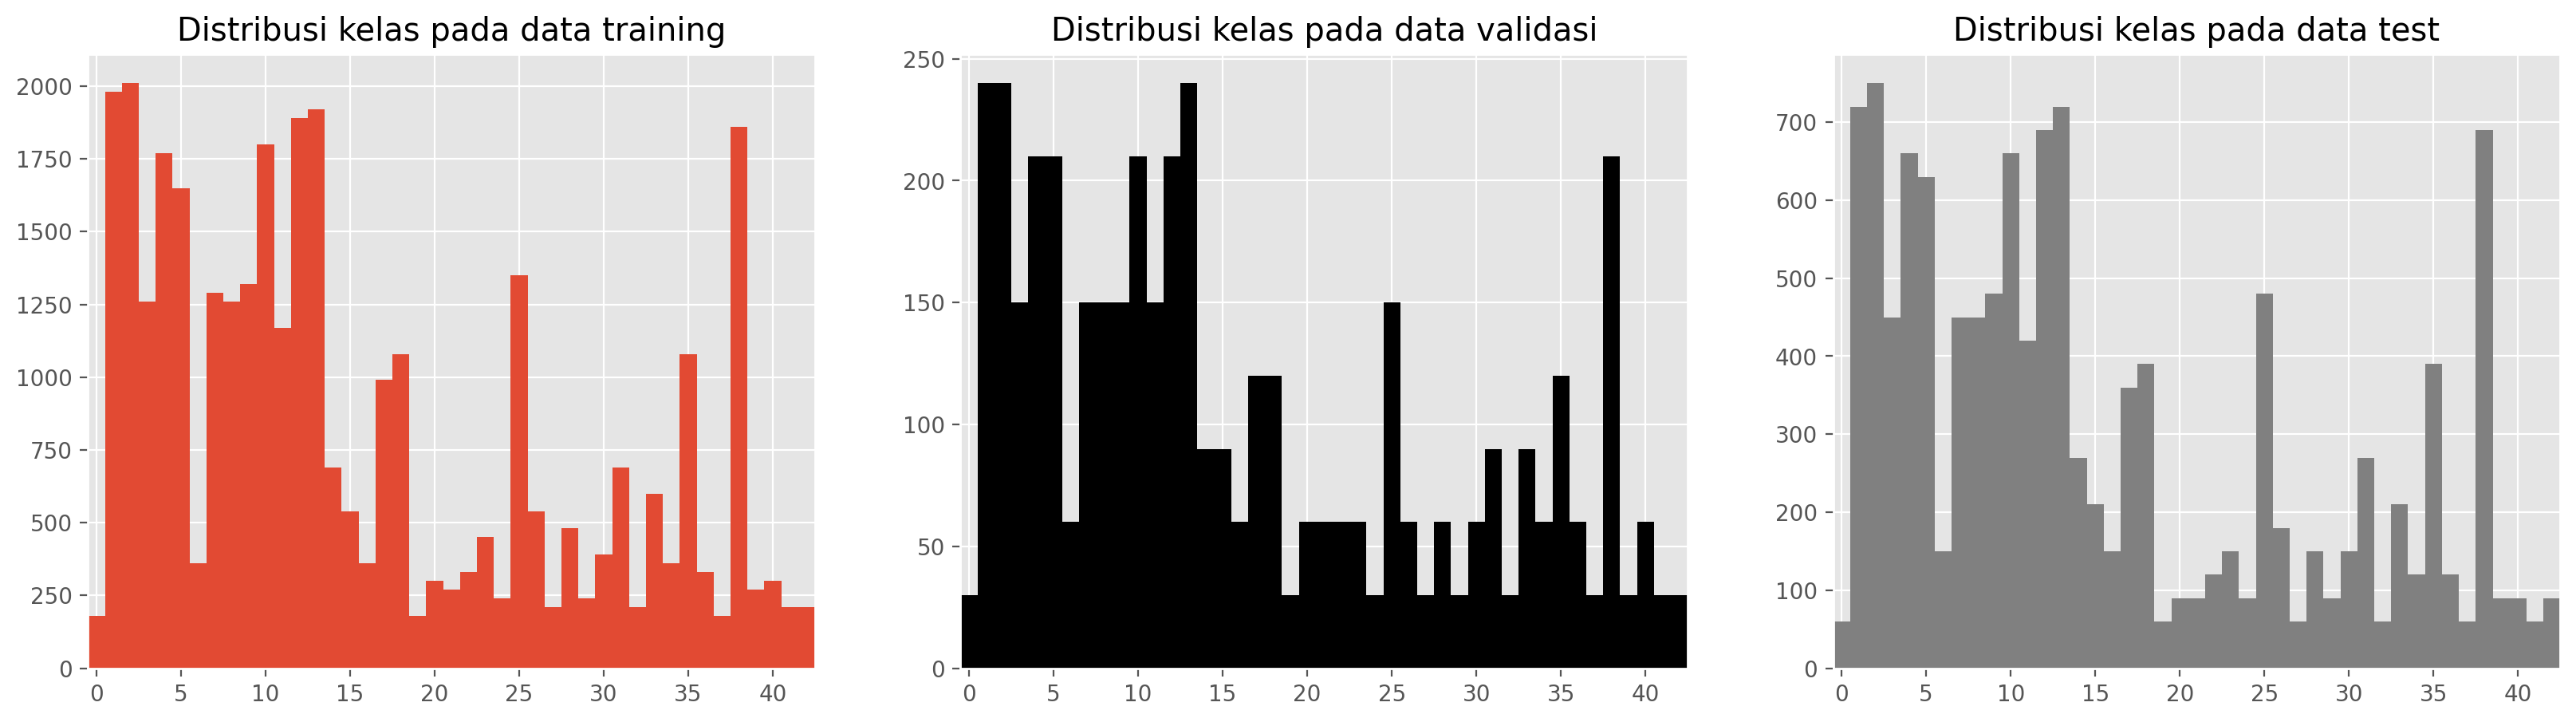

In [16]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

Dari gambar visualisasi di atas terlihat bahwa distribusi kelas masing-masing bagian data terlihat mirip. Oleh karena itu, kita tidak perlu melakukan proses normalisasi.

- Melakukan konversi label data menggunakan teknik **one hot encoding** (mengubah tipe data **string** menjadi fitur **kategorik**)

In [17]:
# Konversi label dengan teknik one hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

# 4. Training Model

- Membuat fungsi **callback** untuk menghentikan proses pelatihan ketika sudah mencapai tingkat parameter yang diinginkan

In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True

callbacks = myCallback()

- Membuat model menggunakan CNN

In [19]:
# Building the model
model = Sequential()

# First layer
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

# Second layer
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third layer
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

- Melakukan kompilasi model dan memanggil fungsi **fit** untuk memulai proses pelatihan model

In [20]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
1088/1088 [==============================] - 146s 131ms/step - loss: 1.5819 - accuracy: 0.6027 - val_loss: 0.3246 - val_accuracy: 0.9073
Epoch 2/25
1088/1088 [==============================] - 140s 129ms/step - loss: 0.4107 - accuracy: 0.8800 - val_loss: 0.1632 - val_accuracy: 0.9617
Epoch 3/25
1088/1088 [==============================] - 138s 127ms/step - loss: 0.2880 - accuracy: 0.9174 - val_loss: 0.1400 - val_accuracy: 0.9669
Epoch 4/25
1088/1088 [==============================] - 158s 146ms/step - loss: 0.2020 - accuracy: 0.9430 - val_loss: 0.1173 - val_accuracy: 0.9673
Epoch 5/25
1088/1088 [==============================] - 178s 164ms/step - loss: 0.2148 - accuracy: 0.9417 - val_loss: 0.1275 - val_accuracy: 0.9698
Epoch 6/25
1088/1088 [==============================] - 142s 130ms/step - loss: 0.2054 - accuracy: 0.9452 - val_loss: 0.1373 - val_accuracy: 0.9705
Epoch 7/25
1088/1088 [==============================] - 143s 131ms/step - loss: 0.1917 - accuracy: 0.9517 - val_

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


- Menampilkan grafik nilai akurasi dan loss

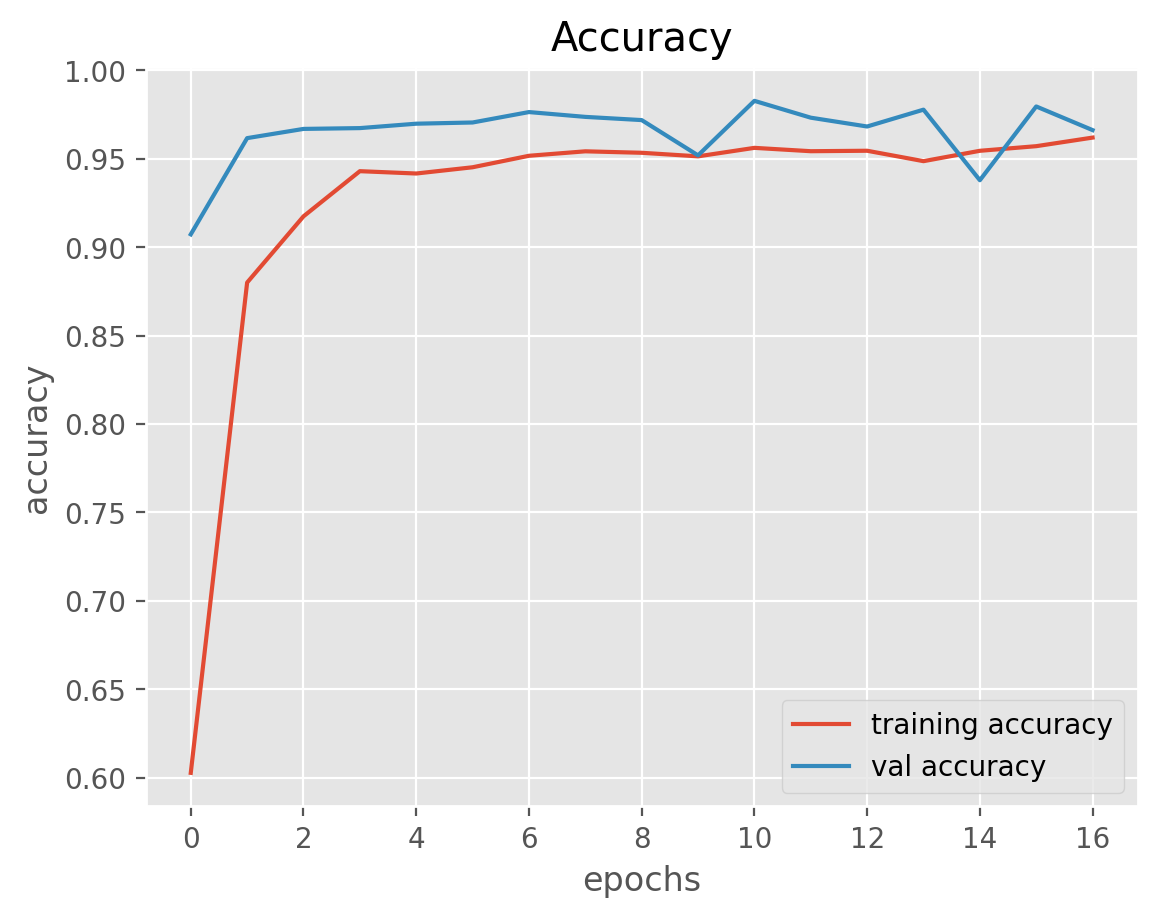

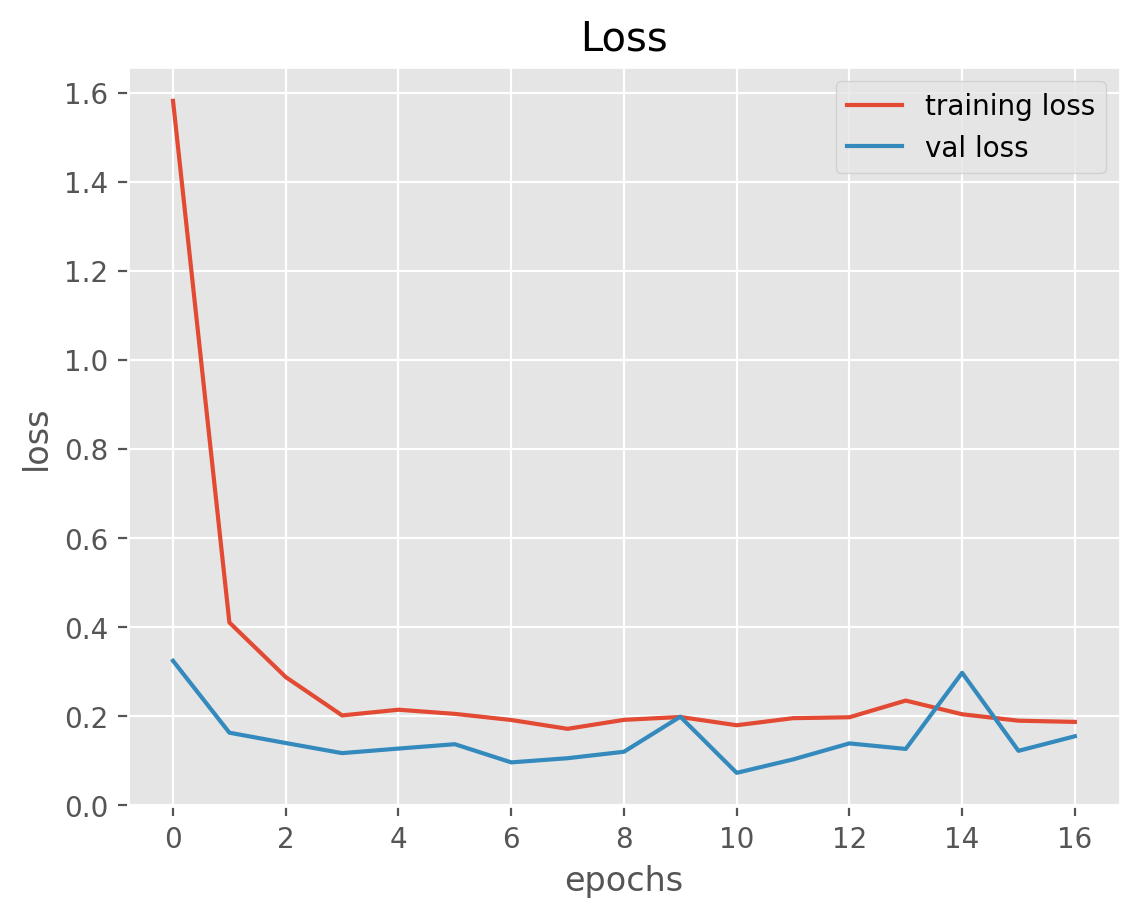

In [21]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# 5. Testing Model

- Menguji akurasi model yang telah dilatih pada data uji

In [22]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score

pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 [==============================] - 13s 34ms/step


0.960965954077593

- Menampilkan **classification report** pada model yang telah dibuat berdasarkan pengujian menggunakan data uji

In [23]:
# Calculate metrics for classification
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       0.93      0.99      0.95       720
           2       0.99      0.96      0.98       750
           3       0.84      0.97      0.90       450
           4       0.99      0.98      0.98       660
           5       0.96      0.87      0.91       630
           6       0.97      0.77      0.86       150
           7       1.00      0.95      0.97       450
           8       0.96      0.98      0.97       450
           9       0.98      1.00      0.99       480
          10       1.00      0.97      0.98       660
          11       0.98      0.96      0.97       420
          12       0.97      0.97      0.97       690
          13       0.98      0.99      0.98       720
          14       0.99      1.00      0.99       270
          15       0.95      0.98      0.96       210
          16       0.97      0.99      0.98       150
          17       1.00    